In [ ]:
import pandas as pd
import numpy as np
import torch
from dotenv import load_dotenv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
import seaborn as sns
from scipy.stats import wasserstein_distance
load_dotenv()


[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Multiple GPUs

    # To ensure deterministic results
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

set_seed(42)

Using device: cuda


In [3]:
# Define directories
data_path = os.getenv('DATA_PATH')
general_path = os.getenv('3DV_PATH')
output_dir_base = os.path.join(general_path, 'embeddings_exp1')
if not os.path.exists(output_dir_base):
    os.makedirs(output_dir_base)
figure_dir_base = os.path.join(general_path, 'figures_exp1')
if not os.path.exists(figure_dir_base):
    os.makedirs(figure_dir_base)
model_path_base = os.path.join(general_path, 'models_exp1')
if not os.path.exists(model_path_base):
    os.makedirs(model_path_base)
generated_betas_path_base = os.path.join(general_path, 'generated_betas_exp1_euclidean_gender_pond')
if not os.path.exists(generated_betas_path_base):
    os.makedirs(generated_betas_path_base)
real_betas_path_base = os.path.join(general_path, 'real_betas_exp1_euclidean_gender_pond')
if not os.path.exists(real_betas_path_base):
    os.makedirs(real_betas_path_base)
fold_base_path = os.path.join(general_path, 'folds_exp1')
if not os.path.exists(fold_base_path):
    os.makedirs(fold_base_path)

In [4]:
df = pd.read_csv(os.path.join(data_path, 'df_final3.csv'))

fat_data = ["Total Fat", "Fat Right Leg", "Fat Left Leg", "Fat Right Arm", "Fat Left Arm", "Fat Trunk"]
antro_data = ["Height", "Weight","Wrist", "Waist", "Hip", "WHR"]
muscle_data = ["Total Muscle", "Muscle Right Leg", "Muscle Left Leg", "Muscle Right Arm", "Muscle Left Arm", "Muscle Trunk"]
beta_data = ["beta0", "beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]

modality_columns = {
    'fat_data': fat_data,
    'antro_data': antro_data,
    'muscle_data': muscle_data,
    'beta_data': beta_data
}

modalities = {
    'fat_data': df[fat_data],
    'antro_data': df[antro_data],
    'muscle_data': df[muscle_data],
    'beta_data': df[beta_data]
}

# Train models and save metrics

In [6]:
clientes = df['cliente'].unique()
print(f"Number of unique clients: {len(clientes)}")

Number of unique clients: 124


In [ ]:
def contrastive_loss(fat_embedding, antro_embedding, muscle_embedding, beta_embedding, temperature = 0.1):
    fat_embedding = F.normalize(fat_embedding, dim=1)
    antro_embedding = F.normalize(antro_embedding, dim=1)
    muscle_embedding = F.normalize(muscle_embedding, dim=1)
    beta_embedding = F.normalize(beta_embedding, dim=1)

    device = fat_embedding.device
    T = torch.exp(torch.tensor(temperature).to(device))
    labels = torch.arange(fat_embedding.size(0)).to(device)

    def pairwise_contrastive(x, y):
        logits = torch.mm(x, y.T) / T
        loss_x = F.cross_entropy(logits, labels)
        loss_y = F.cross_entropy(logits.T, labels)
        return (loss_x + loss_y) / 2

    loss_fat_beta = pairwise_contrastive(fat_embedding, beta_embedding)
    loss_antro_beta = pairwise_contrastive(antro_embedding, beta_embedding)
    loss_muscle_beta = pairwise_contrastive(muscle_embedding, beta_embedding)

    contrastive_loss = (loss_fat_beta + loss_antro_beta + loss_muscle_beta) / 3
    return contrastive_loss

def calculate_distances(fat_embeddings, antro_embeddings, muscle_embeddings, beta_embeddings, dim=1):
    cos = nn.CosineSimilarity(dim=dim)
    cont = 0
    acc_1 = 0
    acc_2 = 0
    acc_3 = 0
    embed_size = len(fat_embeddings)
    print(len(fat_embeddings), len(antro_embeddings), len(muscle_embeddings), len(beta_embeddings))
    for idx in range(len(fat_embeddings)):
        sim_beta_fat = cos(beta_embeddings[idx], fat_embeddings[idx])
        sim_beta_antro = cos(beta_embeddings[idx], antro_embeddings[idx])
        sim_beta_muscle = cos(beta_embeddings[idx], muscle_embeddings[idx])
        # print(sim_beta_fat, sim_beta_antro, sim_beta_muscle, cont)
        acc_1 += sim_beta_fat
        acc_2 += sim_beta_antro
        acc_3 += sim_beta_muscle
        cont += 1

    return acc_1/embed_size, acc_2/embed_size, acc_3/embed_size



In [11]:
class MultiModalDataset(Dataset):
    def __init__(self, fat, antro, muscle, beta, gender):
        self.fat = fat
        self.antro = antro
        self.muscle = muscle
        self.beta = beta
        self.gender = gender
        
    def __len__(self):
        return len(self.fat)

    def __getitem__(self, idx):
        return {
            'fat': self.fat[idx],
            'antro': self.antro[idx],
            'muscle': self.muscle[idx],
            'beta': self.beta[idx],
            'gender': self.gender[idx]
        }

In [10]:
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=1024, out_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, out_dim)
        )
        self.classifier = nn.Linear(out_dim, 10)  # Regression head

    def forward(self, x):
        z = self.encoder(x)
        pred = self.classifier(z)
        return z, pred

In [ ]:
def train(model_dict, dataloader, model_params, device=None, epochs=50, save=False, alpha=None):
    optimizer = torch.optim.SGD(model_params, lr=0.0001, weight_decay=1e-4, momentum=0.9)
    loss_history = []
    for epoch in range(epochs):
        model_dict = {k: v.train().to(device) for k, v in model_dict.items()}
        total_loss = 0

        for batch in dataloader:
            fat = batch['fat'].to(device).float()
            antro = batch['antro'].to(device).float()
            muscle = batch['muscle'].to(device).float()
            beta = batch['beta'].to(device).float()

            z_fat, _ = model_dict['fat'](fat)
            z_antro, _ = model_dict['antro'](antro)
            z_muscle, _ = model_dict['muscle'](muscle)
            z_beta, _ = model_dict['beta'](beta)
            loss = contrastive_loss(z_fat, z_antro, z_muscle, z_beta)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}: loss = {avg_loss:.4f}", end='\r')

    if save:
        torch.save(
            {k: v.state_dict() for k, v in model_dict.items()},
            os.path.join(model_path, "clip_tab_model_3dv.pth")
        )

    # 📉 Plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss During Training")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(figure_dir, "loss_training.png"))

In [ ]:
def visualize_embeddings(model_dict, dataset, device='cpu', test: list = None, filtro=None, save=False, trained=True):

    model_dict = {k: v.eval().to(device) for k, v in model_dict.items()}
    fat_latents, antro_latents, muscle_latents, beta_latents = [], [], [], [] 


    with torch.no_grad():
        for i in range(len(dataset)):
            sample = dataset[i]
            z_fat, _ = model_dict['fat'](sample['fat'].unsqueeze(0).to(device).float())
            z_antro, _ = model_dict['antro'](sample['antro'].unsqueeze(0).to(device).float())
            z_muscle, _ = model_dict['muscle'](sample['muscle'].unsqueeze(0).to(device).float())
            z_beta, _ = model_dict['beta'](sample['beta'].unsqueeze(0).to(device).float())

            fat_latents.append(z_fat)
            antro_latents.append(z_antro)
            muscle_latents.append(z_muscle)
            beta_latents.append(z_beta)

    

    print(calculate_distances(fat_latents, antro_latents, muscle_latents, beta_latents))
    test_fat_latents, test_antro_latents, test_muscle_latents, test_beta_latents  = [], [], [], []
    with torch.no_grad():
        for i in range(len(test[0])):
            z_fat_test, _ = model_dict['fat'](test[0][i].unsqueeze(0).to(device).float())
            z_antro_test, _ = model_dict['antro'](test[1][i].unsqueeze(0).to(device).float())
            z_muscle_test, _ = model_dict['muscle'](test[2][i].unsqueeze(0).to(device).float())
            z_beta_test, _ = model_dict['beta'](test[3][i].unsqueeze(0).to(device).float())

            test_fat_latents.append(z_fat_test)
            test_antro_latents.append(z_antro_test)
            test_muscle_latents.append(z_muscle_test)
            test_beta_latents.append(z_beta_test)

    print("Calculating Test Distances")
    print(calculate_distances(test_fat_latents, test_antro_latents, test_muscle_latents, test_beta_latents))
    fat_latents = torch.cat(fat_latents).cpu().numpy()
    muscle_latents = torch.cat(muscle_latents).cpu().numpy()
    antro_latents = torch.cat(antro_latents).cpu().numpy()
    beta_latents = torch.cat(beta_latents).cpu().numpy()

    test_fat_latents = torch.cat(test_fat_latents).cpu().numpy()
    test_muscle_latents = torch.cat(test_muscle_latents).cpu().numpy()
    test_antro_latents = torch.cat(test_antro_latents).cpu().numpy()
    test_beta_latents = torch.cat(test_beta_latents).cpu().numpy()

    all_latents = np.concatenate([fat_latents, antro_latents, muscle_latents, beta_latents], axis=0)
    tsne = TSNE(n_components=2, random_state=42, metric="euclidean")
    reduced = tsne.fit_transform(all_latents)
    modalities = ["Fat", "Anthro", "Muscle", "Beta"]
    N = fat_latents.shape[0]  # Number of samples
    reduced = reduced.reshape(len(modalities), N, 2).transpose(1, 0, 2)  # (7, N, 2) -> (N, 7, 2)

    # # Step 3: apply filter if specified
    if filtro:
        reduced = reduced[np.array(filtro)]
        classes = np.array(classes)[np.array(filtro)]

    
    modality_colors = {"Fat":"red", "Anthro":"green",
                    "Muscle":"orange", "Beta":"blue"}

    plt.figure(figsize=(12, 8))
    for i in range(len(reduced)):
        coords = reduced[i]  # shape (7, 2)
        for j, mod in enumerate(modalities):
            plt.scatter(
                coords[j, 0], coords[j, 1],
                color=modality_colors[mod],
                label=mod if i == 0 else "",
                alpha=0.7
            )
            # plt.text(
            #     coords[j, 0] + 0.5,
            #     coords[j, 1],
            #     str(i),
            #     fontsize=8,
            #     color=modality_colors[mod],
            #     alpha=0.8
            # )

    plt.title("t-SNE Visualization")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) 
    plt.legend(by_label.values(), by_label.keys(), loc="best")
    plt.tight_layout()



    # Save latent representations
    if save and trained:
        # Training
        np.save(os.path.join(output_dir, "fat_latents.npy"), fat_latents)
        np.save(os.path.join(output_dir, "antro_latents.npy"), antro_latents)
        np.save(os.path.join(output_dir, "muscle_latents.npy"), muscle_latents)
        np.save(os.path.join(output_dir, "beta_latents.npy"), beta_latents)
        # Testing
        np.save(os.path.join(output_dir, "test_fat_latents.npy"), test_fat_latents)
        np.save(os.path.join(output_dir, "test_antro_latents.npy"), test_antro_latents)
        np.save(os.path.join(output_dir, "test_muscle_latents.npy"), test_muscle_latents)
        np.save(os.path.join(output_dir, "test_beta_latents.npy"), test_beta_latents)
        # Reduced
        np.save(os.path.join(output_dir, "reduced.npy"), reduced)
        # Save figure
        plt.savefig(os.path.join(figure_dir, "tsne_plot.png"))
    elif save and not trained:
        # Pre-training
        np.save(os.path.join(output_dir, "pre_fat_latents.npy"), fat_latents)
        np.save(os.path.join(output_dir, "pre_antro_latents.npy"), antro_latents)
        np.save(os.path.join(output_dir, "pre_muscle_latents.npy"), muscle_latents)
        np.save(os.path.join(output_dir, "pre_beta_latents.npy"), beta_latents)
        # Pre-Pruebas
        np.save(os.path.join(output_dir, "pre_test_fat_latents.npy"), test_fat_latents)
        np.save(os.path.join(output_dir, "pre_test_antro_latents.npy"), test_antro_latents)
        np.save(os.path.join(output_dir, "pre_test_muscle_latents.npy"), test_muscle_latents)
        np.save(os.path.join(output_dir, "pre_test_beta_latents.npy"), test_beta_latents)

        # Pre-Reduced
        np.save(os.path.join(output_dir, "pre_reduced.npy"), reduced)
        # Save figure
        plt.savefig(os.path.join(figure_dir, "pre_tsne_plot.png"))

    plt.show()

In [ ]:

kf = GroupKFold(n_splits=10)

array_save_test = []
array_save_train = []
folds = []

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(df, groups=df['cliente'])):
    train_data = df.iloc[train_idx]
    test_data = df.iloc[test_idx]
    print(train_idx)
    print(test_idx)
    train_patients = train_data['cliente'].unique()
    test_patients = test_data['cliente'].unique()
    
    print(f"Fold {fold_idx+1}:")
    print(f"  Patients in train: {len(train_patients)}")
    print(f"  Patients in test: {len(test_patients)}\n")
    array_save_train.append(train_idx)
    array_save_test.append(test_idx)
    folds.append((train_data, test_data))
# Save array_save as npy
fold_base_path = os.path.join(general_path, 'folds_exp1')
np.save(os.path.join(fold_base_path, 'folds.npy'), np.array(array_save_test, dtype=object))
np.save(os.path.join(fold_base_path, 'train_folds.npy'), np.array(array_save_train, dtype=object))

In [ ]:
fat_data = df[["Visceral Fat","Total Fat", "Fat Right Leg", "Fat Left Leg", "Fat Right Arm", "Fat Left Arm", "Fat Trunk"]]
antro_data = df[["Height", "Weight","Wrist", "Waist", "Hip", "WHR"]]
muscle_data = df[["Total Muscle", "Muscle Right Leg", "Muscle Left Leg", "Muscle Right Arm", "Muscle Left Arm", "Muscle Trunk"]]
beta_data = df[["beta0", "beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]]


for fold_idx, fold in enumerate(folds):
    output_dir = os.path.join(output_dir_base, f"fold_{fold_idx}")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    figure_dir = os.path.join(figure_dir_base, f"fold_{fold_idx}")
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)
    model_path = os.path.join(model_path_base, f"fold_{fold_idx}")
    if not os.path.exists(model_path):
        os.makedirs(model_path)


    fat_scaler = StandardScaler()
    antro_scaler = StandardScaler()
    muscle_scaler = StandardScaler()
    beta_scaler = StandardScaler()

    train_data, test_data = fold
    fat_data = torch.tensor(fat_scaler.fit_transform(train_data[["Visceral Fat","Total Fat", "Fat Right Leg", "Fat Left Leg", "Fat Right Arm", "Fat Left Arm", "Fat Trunk"]].values))
    antro_data = torch.tensor(antro_scaler.fit_transform(train_data[["Height", "Weight","Wrist", "Waist", "Hip", "WHR"]].values))
    muscle_data = torch.tensor(muscle_scaler.fit_transform(train_data[["Total Muscle", "Muscle Right Leg", "Muscle Left Leg", "Muscle Right Arm", "Muscle Left Arm", "Muscle Trunk"]].values))
    beta_data = torch.tensor(beta_scaler.fit_transform(train_data[["beta0", "beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]].values))

    fat_test = torch.tensor(fat_scaler.transform(test_data[["Visceral Fat","Total Fat", "Fat Right Leg", "Fat Left Leg", "Fat Right Arm", "Fat Left Arm", "Fat Trunk"]].values))
    antro_test = torch.tensor(antro_scaler.transform(test_data[["Height", "Weight","Wrist", "Waist", "Hip", "WHR"]].values))
    muscle_test = torch.tensor(muscle_scaler.transform(test_data[["Total Muscle", "Muscle Right Leg", "Muscle Left Leg", "Muscle Right Arm", "Muscle Left Arm", "Muscle Trunk"]].values))
    beta_test = torch.tensor(beta_scaler.transform(test_data[["beta0", "beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]].values))
    print(fat_data.shape, antro_data.shape, muscle_data.shape, beta_data.shape)

    gender_train = train_data['Gender'].values
    gender_test = test_data['Gender'].values

    dataset = MultiModalDataset(
        fat_data,
        antro_data,
        muscle_data,
        beta_data,
        gender_train
    )
    test_dataset = MultiModalDataset(
        fat_test,
        antro_test,
        muscle_test,
        beta_test,
        gender_test
    )

    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    model_dict = {
        'fat': MLPEncoder(fat_data.shape[1]),
        'antro': MLPEncoder(antro_data.shape[1]),
        'muscle': MLPEncoder(muscle_data.shape[1]),
        'beta': MLPEncoder(beta_data.shape[1])
    }
    all_params = [p for model in model_dict.values() for p in model.parameters()]
    visualize_embeddings(model_dict, dataset, device=device, test=[fat_test, antro_test, muscle_test, beta_test], filtro=None, save=True, trained=False)
    train(model_dict, dataloader, model_params=all_params, device=device, epochs=2000, save=True, alpha=0.9)
    visualize_embeddings(model_dict, dataset, device=device, test=[fat_test, antro_test, muscle_test, beta_test], filtro=None, save=True, trained=True)

## Load models and show average cosine similarity and retrieval MAE, MSE and MRE. Save real and generated betas for measure module

In [ ]:
def retrieval_function_cosine_threshold(embeddings, query_embedding, threshold=0.8):
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
    query_tensor = torch.tensor(query_embedding, dtype=torch.float32)

    sim = F.cosine_similarity(embeddings_tensor, query_tensor.unsqueeze(0), dim=1)
    indices = torch.where(sim >= threshold)[0].numpy()
    return indices

def load_clip_tab_data(file_path):
    """
    Load the CLIP tab data from a .npy file.
    
    Args:
        file_path (str): Path to the .npy file containing the CLIP tab data.
        
    Returns:
        np.ndarray: Loaded CLIP tab data.
    """
    try:
        data = np.load(file_path, allow_pickle=True)
        return data
    except Exception as e:
        # print(f"Error loading data from {file_path}: {e}")
        return None

def compute_average_cosine_similarity_matrix(modalities):
    acc = 0
    modality_names = list(modalities.keys())
    num_modalities = len(modality_names)
    cos = nn.CosineSimilarity(dim=1)
    matrix = np.zeros((num_modalities, num_modalities))

    for i, src_mod in enumerate(modality_names):
        src_embeddings = modalities[src_mod]  # Tensor shape: [N, D]
        for j, tgt_mod in enumerate(modality_names):
            tgt_embeddings = modalities[tgt_mod]
            # Calcula similitud coseno entre cada par correspondiente
            sim = cos(src_embeddings, tgt_embeddings)
            matrix[i, j] = sim.mean().item()
            acc += matrix[i, j]
    prom_cos = acc / (num_modalities ** 2)
    print(f"Average Cosine Similarity: {prom_cos:.4f}")
    print(modality_names)
    return prom_cos, pd.DataFrame(matrix, index=modality_names, columns=modality_names)

def save_heatmap(df, save_path, title="", mask=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="viridis", mask=mask, fmt=".2f")
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

def retrieval_function(embeddings, query_embedding, top_k=5, distance_metric='euclidean'):
    """
    Retrieve the top_k most similar embeddings to the query_embedding.
    

    Args:
        embeddings (np.ndarray): Array of embeddings to search in.
        query_embedding (np.ndarray): The embedding to compare against.
        top_k (int): Number of top similar embeddings to return.
        
    Returns:
        list: Indices of the top_k most similar embeddings.
    """
    if distance_metric == 'cosine':
        cos = nn.CosineSimilarity(dim=1)
        similarities = cos(torch.tensor(embeddings), torch.tensor(query_embedding))
        top_values, top_indices = torch.topk(similarities, k=top_k)
        
        return top_indices.numpy(), top_values.numpy()
    elif distance_metric == 'euclidean':
    
        embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
        query_tensor = torch.tensor(query_embedding, dtype=torch.float32).unsqueeze(0)  # (1 x D)
        
        distances = torch.norm(embeddings_tensor - query_tensor, dim=1)  # (N,)
        
        top_distances, top_indices = torch.topk(-distances, k=top_k)
        top_distances = -top_distances
        
        return top_indices.numpy(), top_distances.numpy()
    elif distance_metric == 'wasserstein':
        distances = []
        for emb in embeddings:
            dist = wasserstein_distance(emb, query_embedding)
            distances.append(dist)
        distances = np.array(distances)
        top_indices = np.argsort(distances)[:top_k]
        top_distances = distances[top_indices]
        return top_indices, top_distances

def calculate_normalized_mae(df, row1_idx, row2_idx, columns=None):
    """
    Calculate the MAE, NMAE, and baseline MAE between two rows of a DataFrame.
    Args:
        df (pd.DataFrame): Data.
        row1_idx (int): Index of the first row (prediction).
        row2_idx (int): Index of the second row (ground truth).
        columns (list, optional): Columns to compare.

    Returns:
        dict: Contains 'mae', 'nmae' and 'baseline_mae'.
    """
    if columns is not None:
        row1 = df.iloc[row1_idx][columns].astype(float)
        row2 = df.iloc[row2_idx][columns].astype(float)
    else:
        row1 = df.iloc[row1_idx].astype(float)
        row2 = df.iloc[row2_idx].astype(float)

    # MAE entre filas
    mae = np.mean(np.abs(row1 - row2))

    # MAE de un modelo trivial que predice la media de la fila real
    baseline = np.full_like(row2, row2.mean())
    baseline_mae = np.mean(np.abs(baseline - row2))
    # MSE
    mse = mean_squared_error(row2, row1)

    # NMAE: normalizado por la media del valor real
    nmae = mae / row2.mean() if row2.mean() != 0 else np.nan

    with np.errstate(divide='ignore', invalid='ignore'):
        relative_errors = np.abs(row1 - row2) / np.abs(row2)
        relative_errors = relative_errors[~np.isnan(relative_errors) & ~np.isinf(relative_errors)]
        mre = np.mean(relative_errors) if len(relative_errors) > 0 else np.nan

    return {
        'mae': mae,
        'mse': mse,
        'mre': mre,
        # 'baseline_mae': baseline_mae
    }

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'df_final3.csv'))
distance_metric = 'euclidean'
test_fat_acc = []
test_antro_acc = []
test_muscle_acc = []
total_acc_mae_ours = [] 
total_acc_mre_ours = [] 
total_acc_mse_ours = [] 
all_modalities = list(set(fat_data + antro_data + muscle_data + beta_data))
df_gender = df[["Gender"]]
df = df[all_modalities]
modalities = ['fat', 'antro', 'muscle', 'full']
test_folds = np.load(os.path.join(fold_base_path, 'folds.npy'), allow_pickle=True)
train_folds = np.load(os.path.join(fold_base_path, 'train_folds.npy'), allow_pickle=True)

for folder, train_fold, test_fold in zip(os.listdir(output_dir_base), train_folds, test_folds):

    output_dir = os.path.join(output_dir_base, folder)
    antro_latents = load_clip_tab_data(os.path.join(output_dir, "antro_latents.npy"))
    demo_latents = load_clip_tab_data(os.path.join(output_dir, "demo_latents.npy"))
    fat_latents = load_clip_tab_data(os.path.join(output_dir, "fat_latents.npy"))
    muscle_latents = load_clip_tab_data(os.path.join(output_dir, "muscle_latents.npy"))
    beta_latents = load_clip_tab_data(os.path.join(output_dir, "beta_latents.npy"))
    # Embedings from testing
    test_antro_latents = load_clip_tab_data(os.path.join(output_dir, "test_antro_latents.npy"))
    test_demo_latents = load_clip_tab_data(os.path.join(output_dir, "test_demo_latents.npy"))
    test_fat_latents = load_clip_tab_data(os.path.join(output_dir, "test_fat_latents.npy"))
    test_muscle_latents = load_clip_tab_data(os.path.join(output_dir, "test_muscle_latents.npy"))
    test_beta_latents = load_clip_tab_data(os.path.join(output_dir, "test_beta_latents.npy"))

    test_fat_sim, test_antro_sim, test_muscle_sim = calculate_distances(torch.tensor(test_fat_latents), torch.tensor(test_antro_latents), torch.tensor(test_muscle_latents), torch.tensor(test_beta_latents), dim=0)
    test_fat_acc.append(test_fat_sim.item())
    test_antro_acc.append(test_antro_sim.item())
    test_muscle_acc.append(test_muscle_sim.item())

    # Proceso de recuperación
    for modality in modalities:
        if modality == 'fat':
            embedding_search, embedding_search_test = fat_latents, test_fat_latents
        elif modality == 'antro':
            embedding_search, embedding_search_test = antro_latents, test_antro_latents
        elif modality == 'muscle':
            embedding_search, embedding_search_test = muscle_latents, test_muscle_latents
        elif modality == 'full': 
            embedding1, embedding1_test = fat_latents, test_fat_latents
            embedding2, embedding2_test = antro_latents, test_antro_latents
            embedding3, embedding3_test = muscle_latents, test_muscle_latents
            embedding_search, embedding_search_test = np.concatenate([embedding1, embedding2, embedding3], axis=1), np.concatenate([embedding1_test, embedding2_test, embedding3_test], axis=1)

        train_data = df.loc[train_fold]
        test_data = df.loc[test_fold]
        mod_data = train_data[beta_data].columns.tolist()
        num_k = 3
        acc_mae_ours = 0
        acc_mre_ours = 0
        acc_mse_ours = 0
        real_betas = []
        generated_betas = []
        neighbors_data = []
        real_data_with_gender = []
        
        train_retrieval_embeddings = embedding_search 
        
        for test_index in range(len(embedding_search_test)):
            df_missing = df.copy()
            true_values = test_data.iloc[test_index][mod_data].copy()
            df_missing.loc[test_fold[test_index], mod_data] = np.nan
            real_betas.append(true_values.values)
            
            real_gender = df_gender.loc[test_fold[test_index], 'Gender']
            real_data_with_gender.append([true_values.values, real_gender])
            
            query_embedding = embedding_search_test[test_index]
            
            retrieved_indices, top_distances = retrieval_function(embeddings=train_retrieval_embeddings, 
                                                query_embedding=query_embedding, 
                                                top_k=num_k, distance_metric=distance_metric)
            
            actual_train_indices = [train_fold[idx] for idx in retrieved_indices]
            
            neighbor_betas = df.loc[actual_train_indices, mod_data].values
            neighbor_genders = df_gender.loc[actual_train_indices, 'Gender'].values
            
            if distance_metric == 'cosine':
                similarities = top_distances  
                epsilon = 1e-8
                positive_similarities = similarities - similarities.min() + epsilon 
                weights = positive_similarities / positive_similarities.sum()
            elif distance_metric in ['euclidean', 'wasserstein']:
                epsilon = 1e-8
                inv_distances = 1 / (top_distances + epsilon)
                weights = inv_distances / inv_distances.sum()
            
            neighbors_data.append([neighbor_betas, neighbor_genders, weights])
            
            mean_values = np.average(neighbor_betas, axis=0, weights=weights)
            
            df_retrieval_manual = df_missing.copy()
            df_retrieval_manual.loc[test_fold[test_index], mod_data] = mean_values
            generated_betas.append(mean_values)
            
            mae_retrieval_manual = calculate_normalized_mae(
                df=pd.concat([df_retrieval_manual, df.loc[[test_fold[test_index]]]]),
                row1_idx=test_fold[test_index],
                row2_idx=len(df), 
                columns=mod_data
            )
            acc_mae_ours += mae_retrieval_manual['mae']
            acc_mre_ours += mae_retrieval_manual['mre']
            acc_mse_ours += mae_retrieval_manual['mse']

        acc_mae_ours /= len(embedding_search_test)
        acc_mre_ours /= len(embedding_search_test)
        acc_mse_ours /= len(embedding_search_test)
        print(f"MAE of our retrieval method: {acc_mae_ours:.4f}")
        print(f"MRE of our retrieval method: {acc_mre_ours:.4f}")
        print(f"MSE of our retrieval method: {acc_mse_ours:.4f}")
        total_acc_mae_ours.append(acc_mae_ours)
        total_acc_mre_ours.append(acc_mre_ours)
        total_acc_mse_ours.append(acc_mse_ours)   

        generated_betas_path = os.path.join(generated_betas_path_base, f"generated_betas_{folder}-{modality}.npy")
        real_betas_path = os.path.join(real_betas_path_base, f"real_betas_{folder}-{modality}.npy")
        
        neighbors_array = np.empty(len(neighbors_data), dtype=object)
        for i, data in enumerate(neighbors_data):
            neighbors_array[i] = data
            
        real_array = np.empty(len(real_data_with_gender), dtype=object)
        for i, data in enumerate(real_data_with_gender):
            real_array[i] = data
        
        np.save(generated_betas_path, neighbors_array)
        np.save(real_betas_path, real_array)

    print(f"MAE of our retrieval method: {np.mean(total_acc_mae_ours):.4f} Std: {np.std(total_acc_mae_ours):.4f}")
    print(f"MRE of our retrieval method: {np.mean(total_acc_mre_ours):.4f} Std: {np.std(total_acc_mre_ours):.4f}")
    print(f"MSE of our retrieval method: {np.mean(total_acc_mse_ours):.4f} Std: {np.std(total_acc_mse_ours):.4f}")

## Visualize Embeddings

50 50 50 50
442 442 442 442


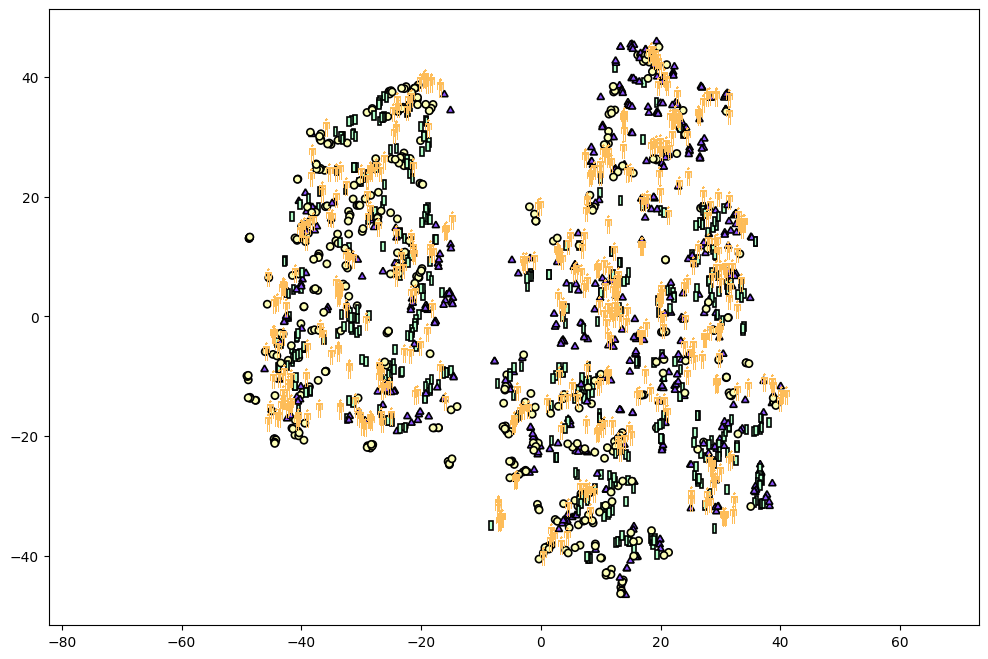

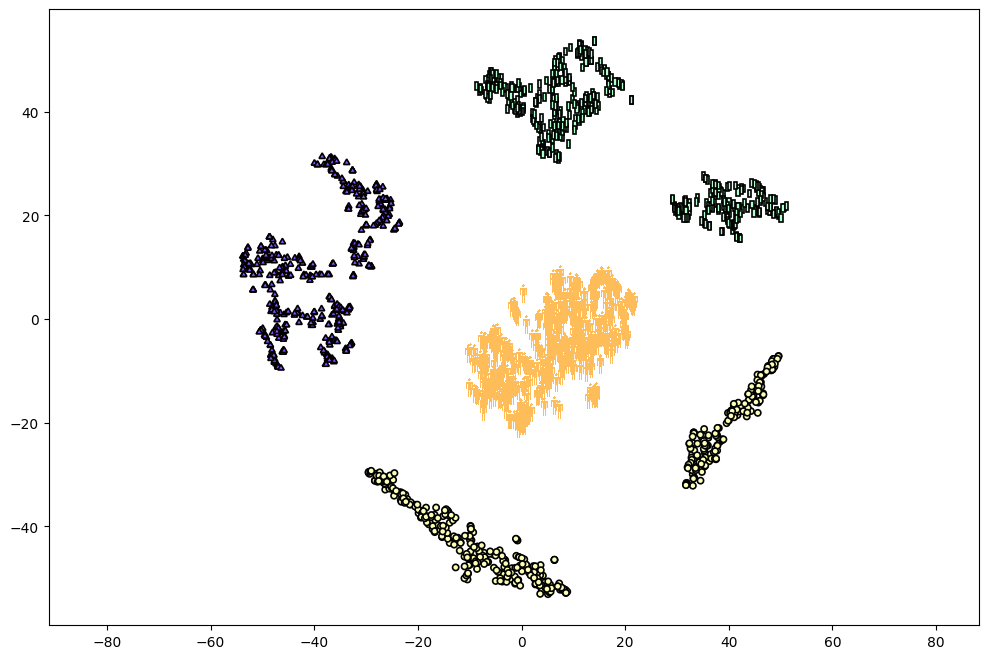

50 50 50 50
442 442 442 442


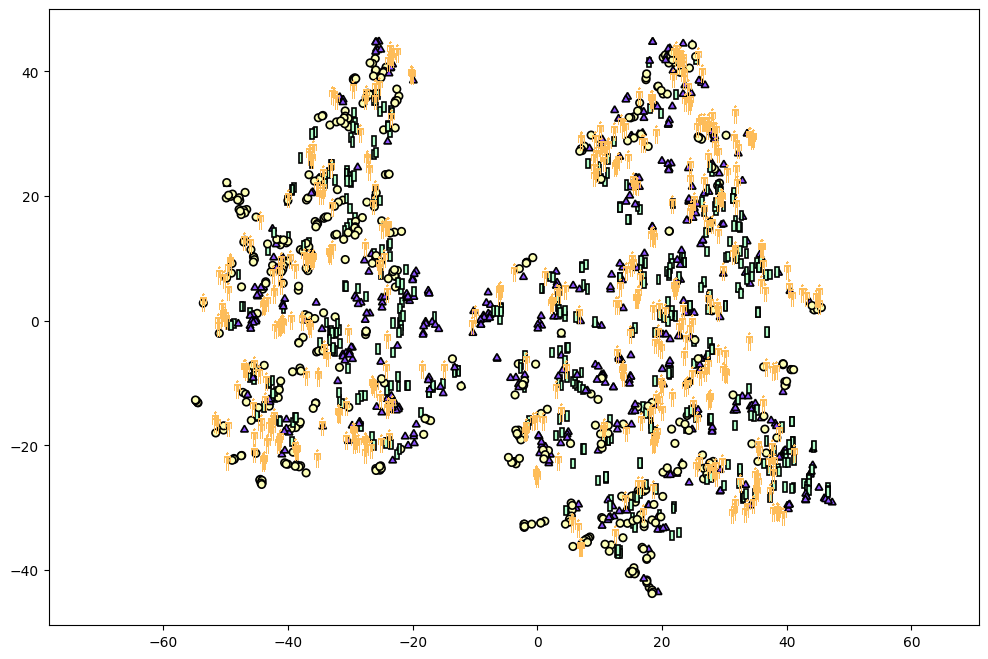

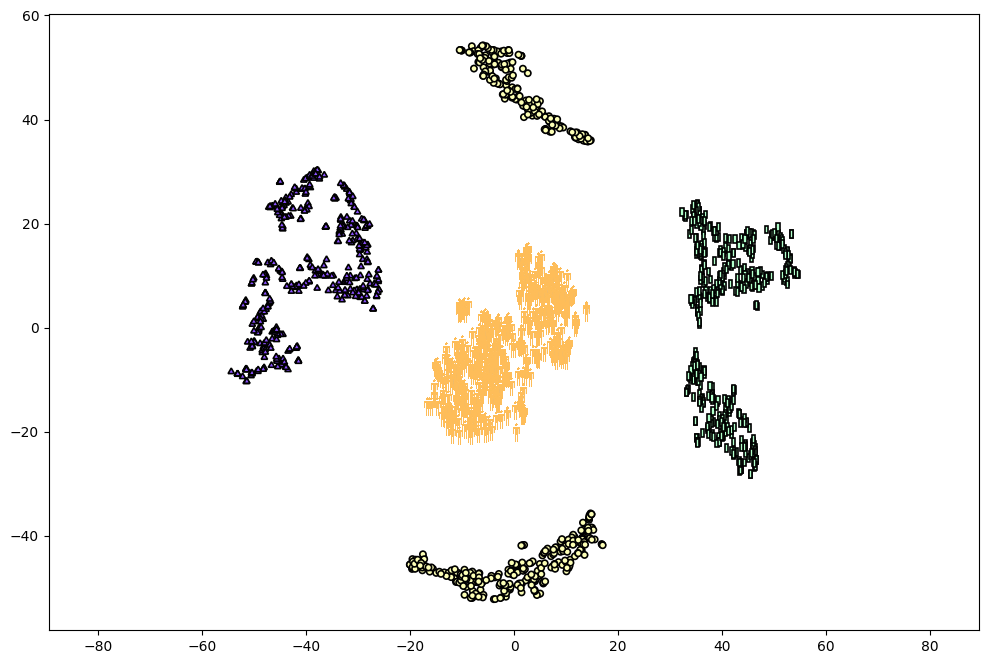

49 49 49 49
443 443 443 443


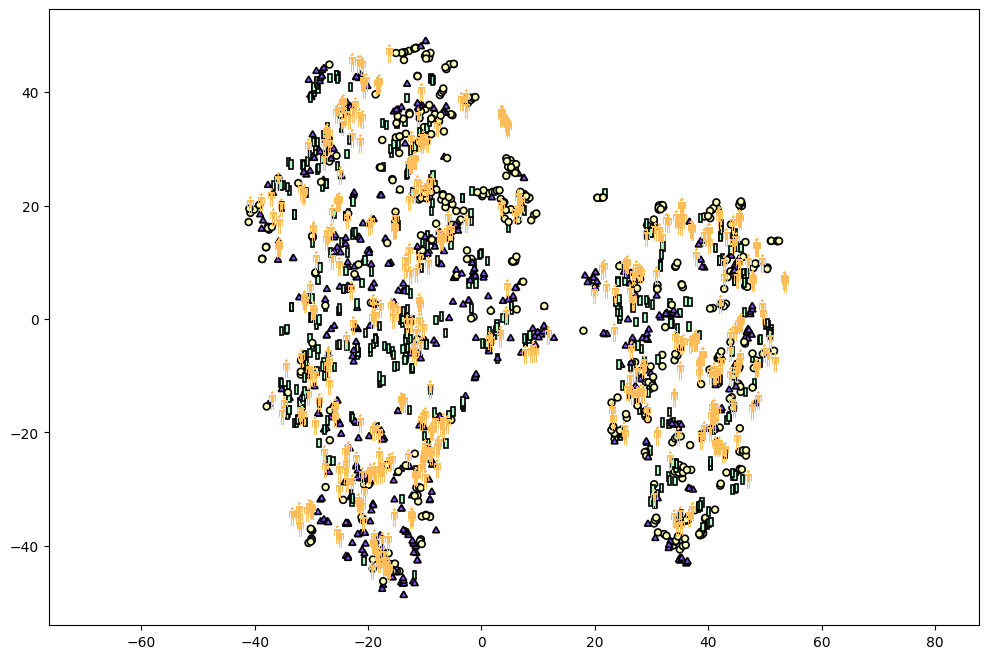

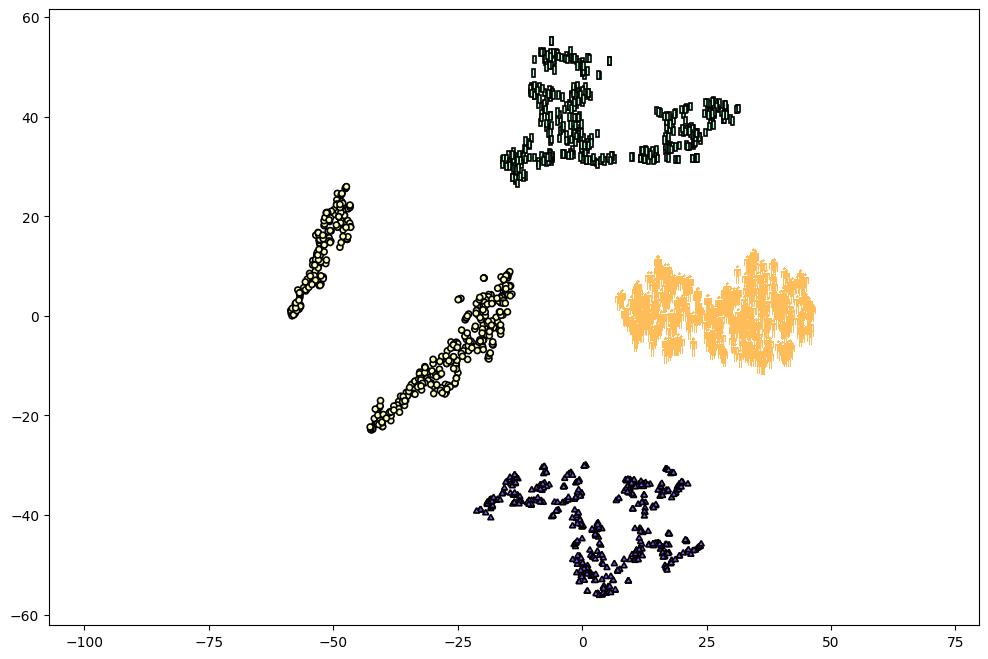

49 49 49 49
443 443 443 443


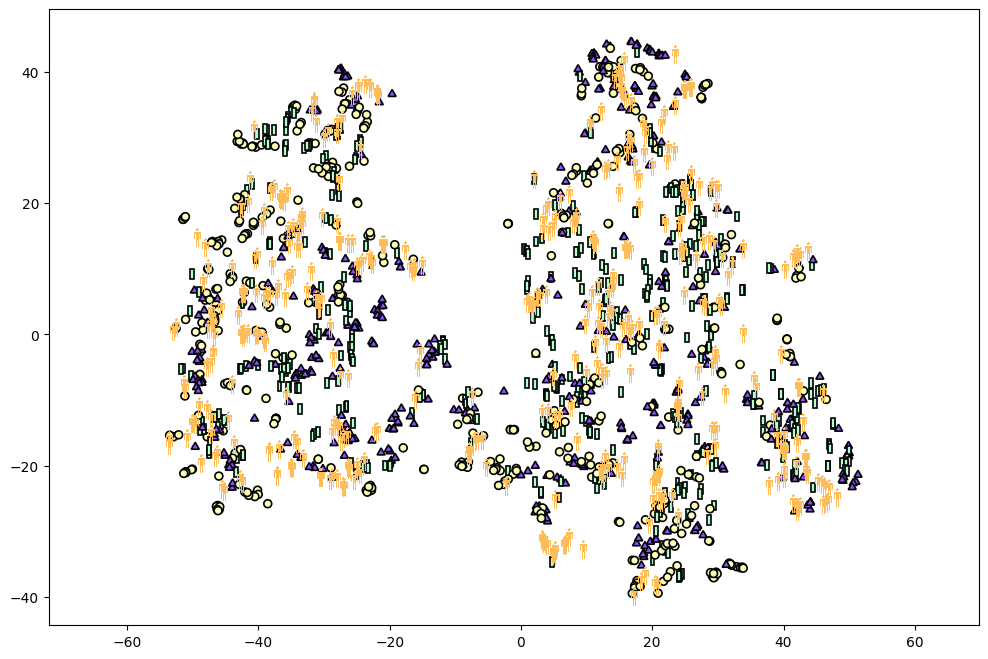

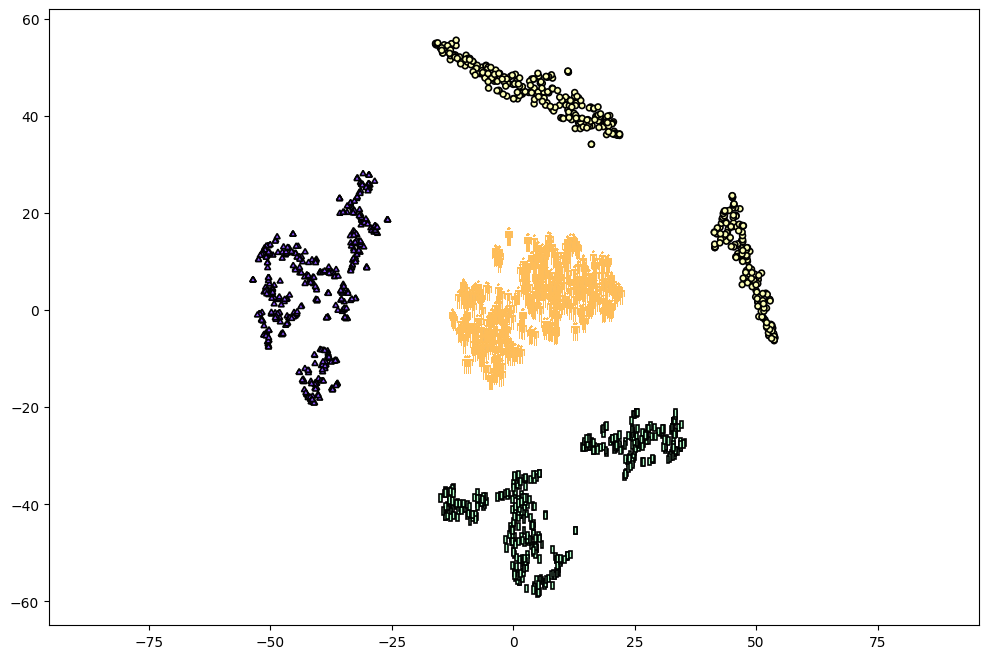

49 49 49 49
443 443 443 443


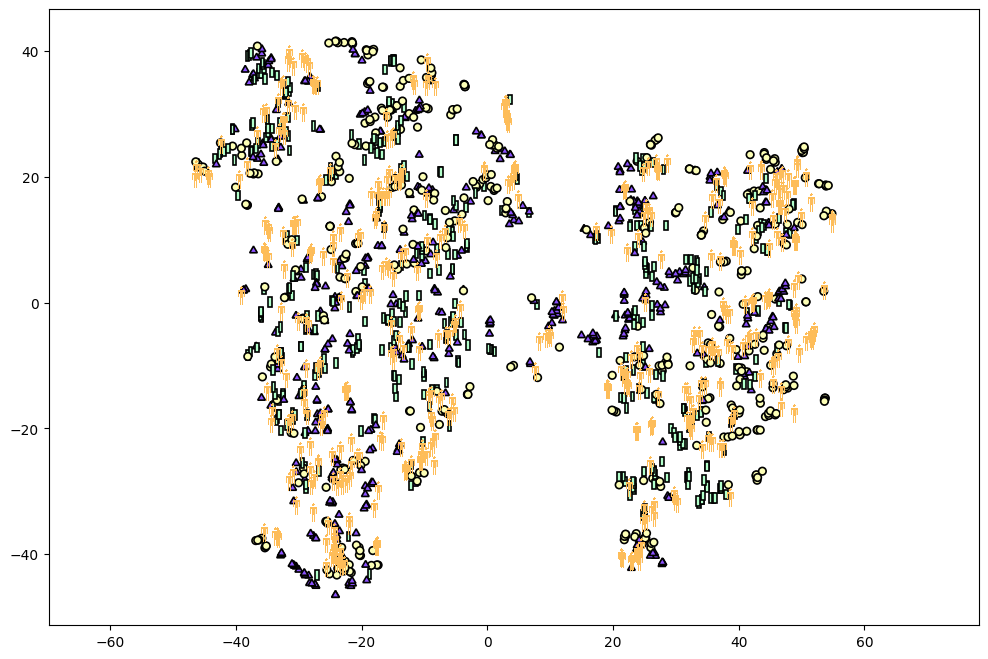

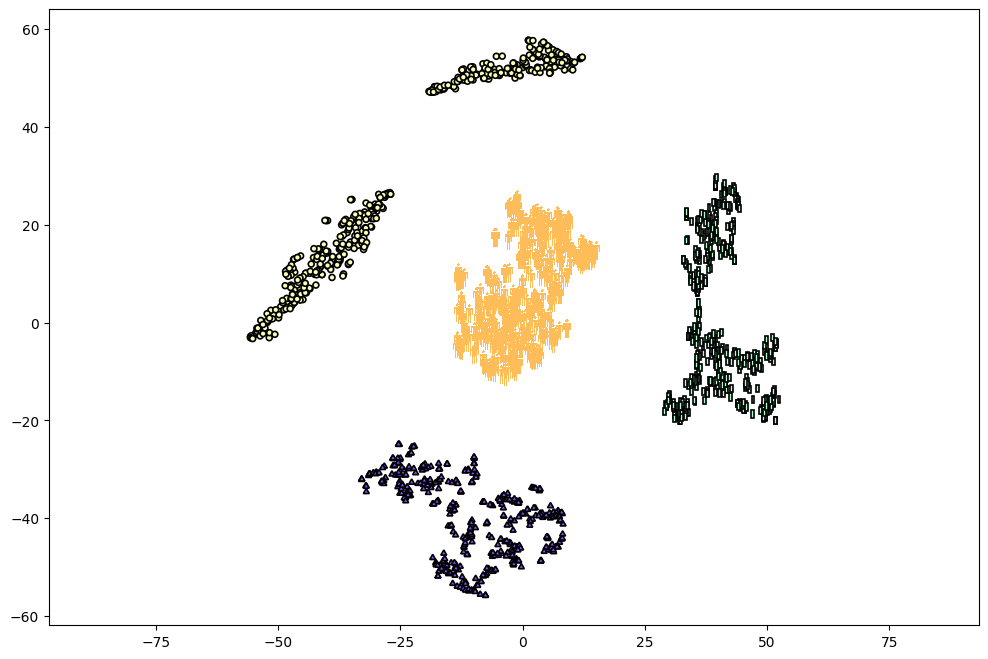

49 49 49 49
443 443 443 443


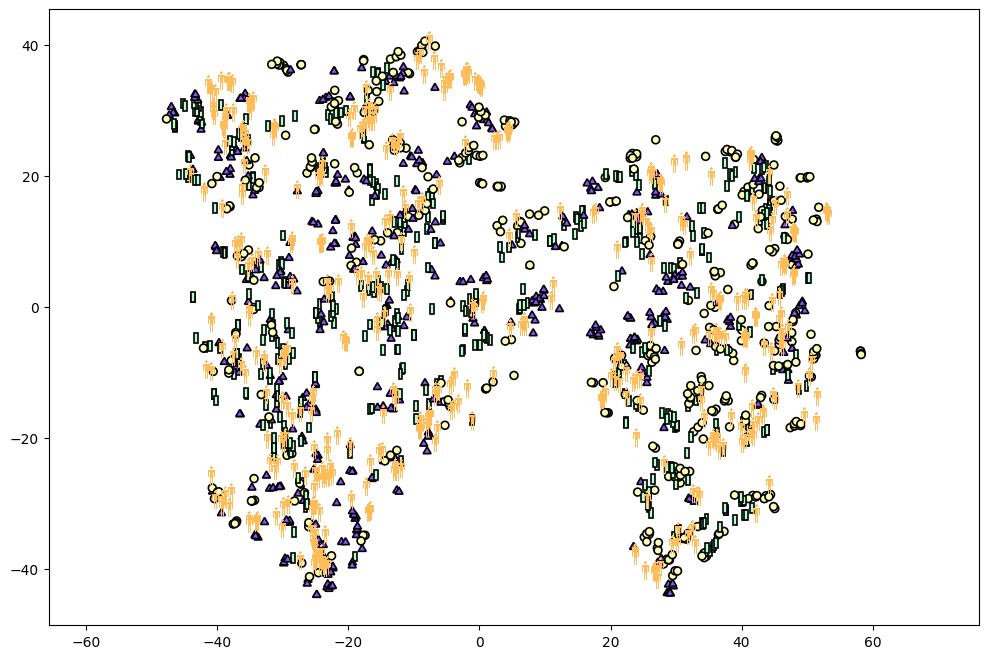

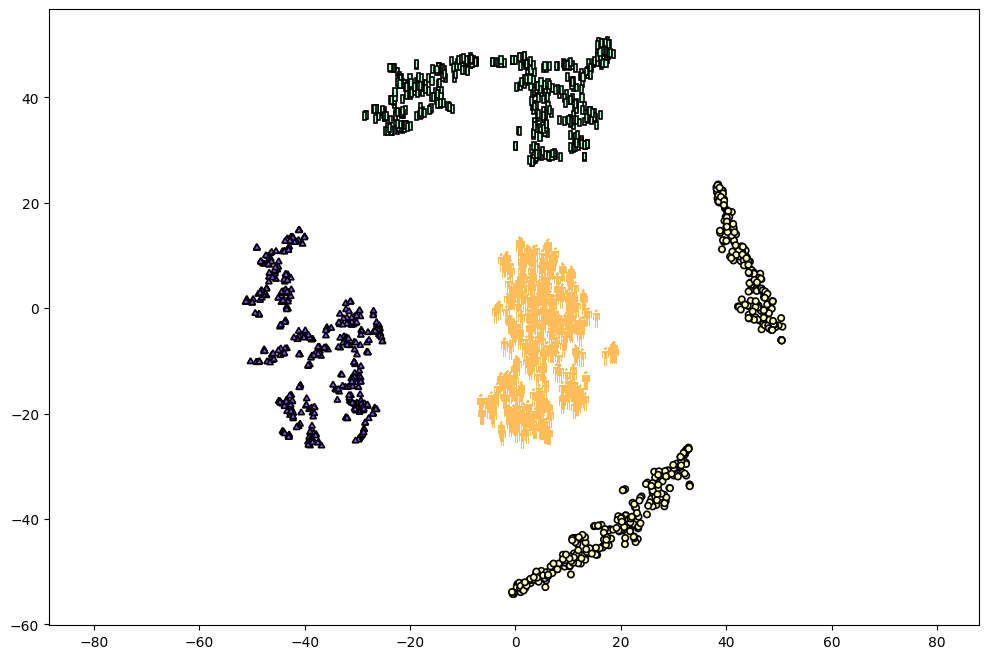

49 49 49 49
443 443 443 443


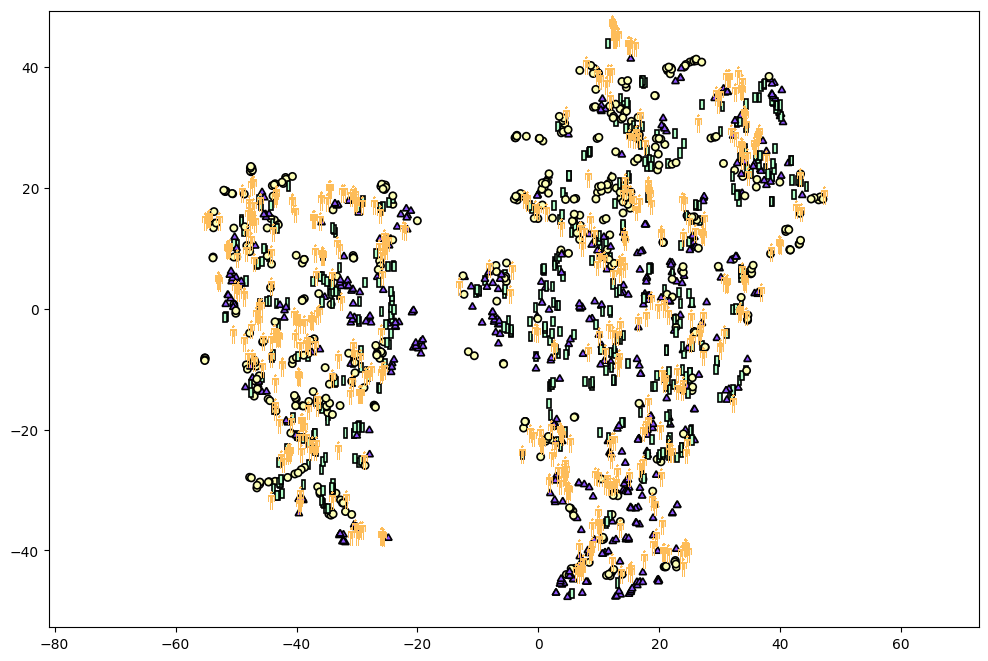

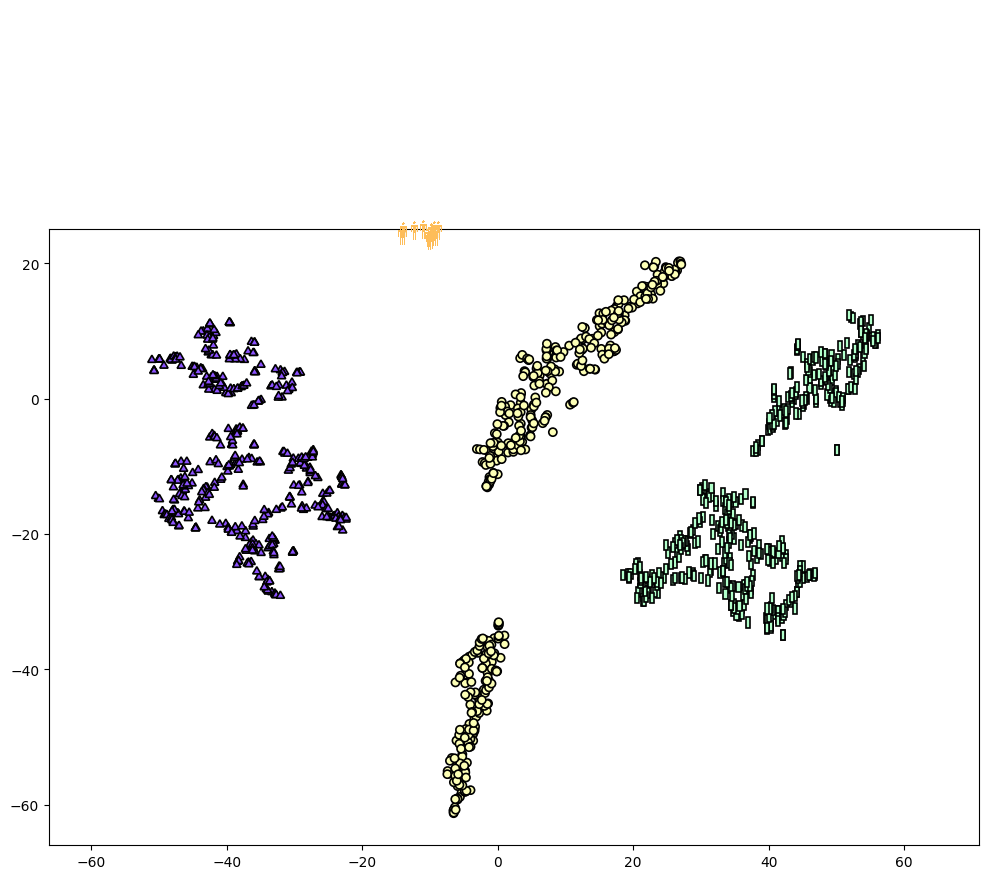

49 49 49 49
443 443 443 443


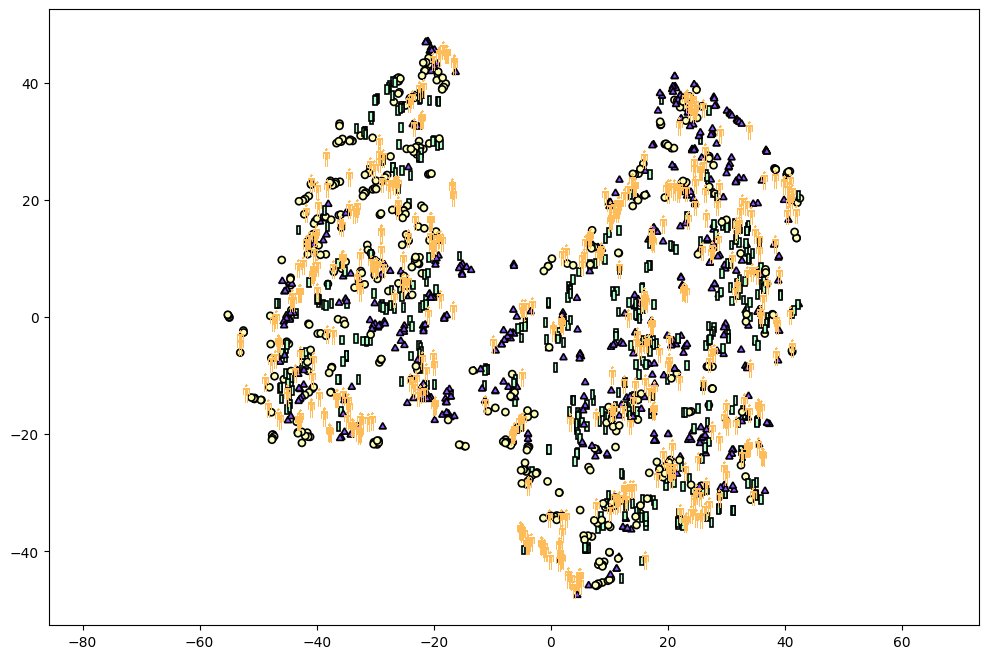

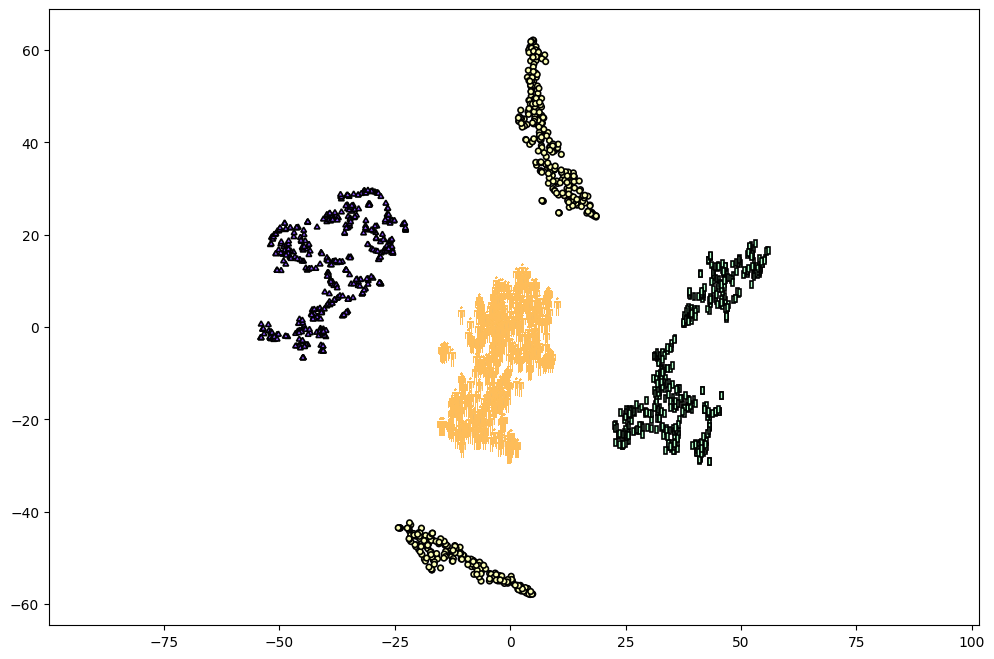

49 49 49 49
443 443 443 443


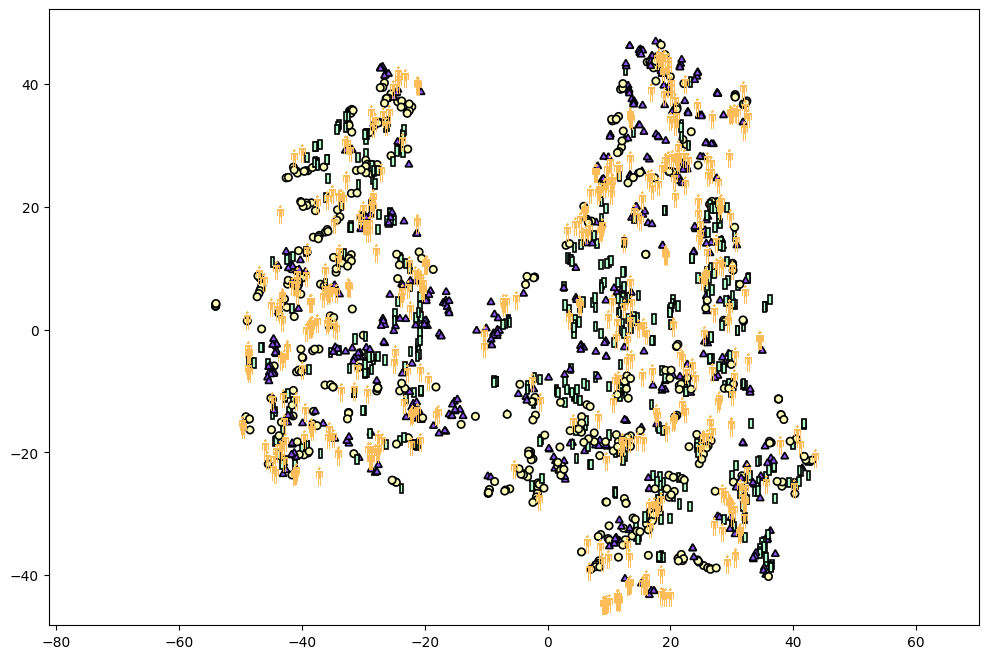

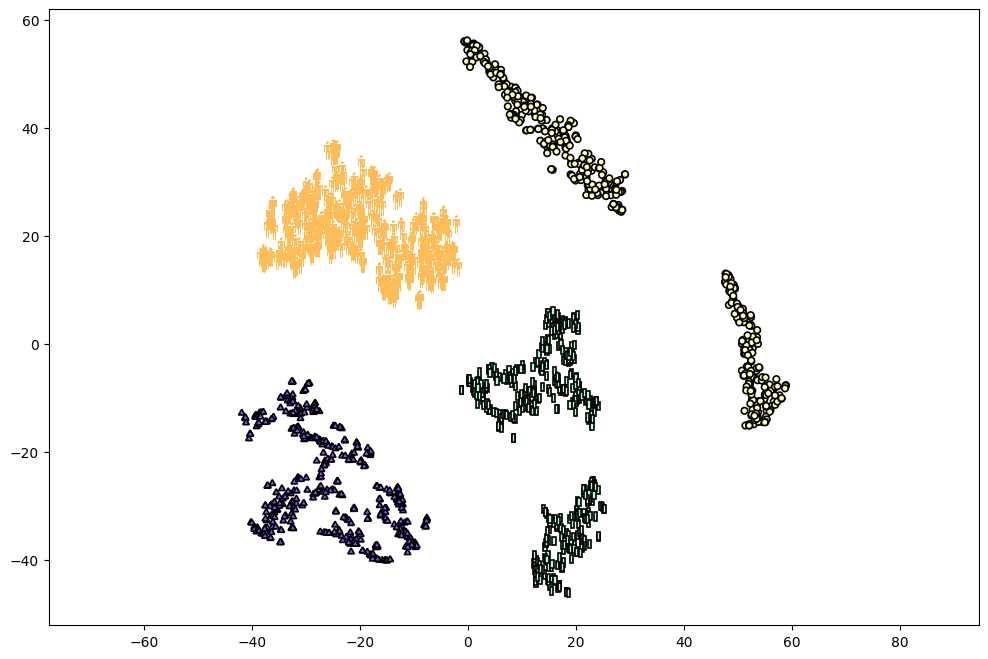

49 49 49 49
443 443 443 443


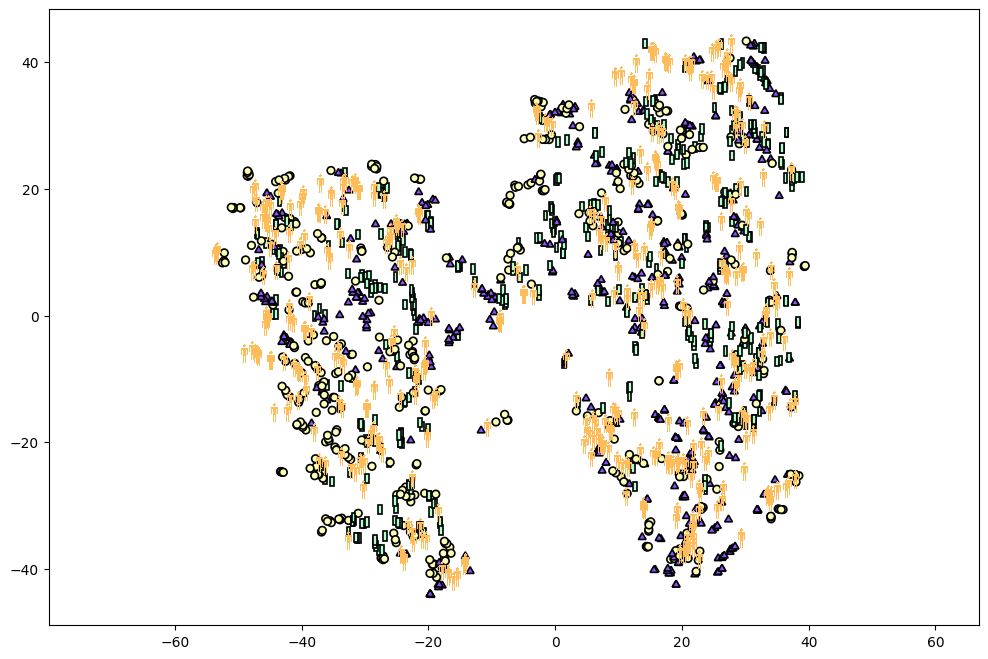

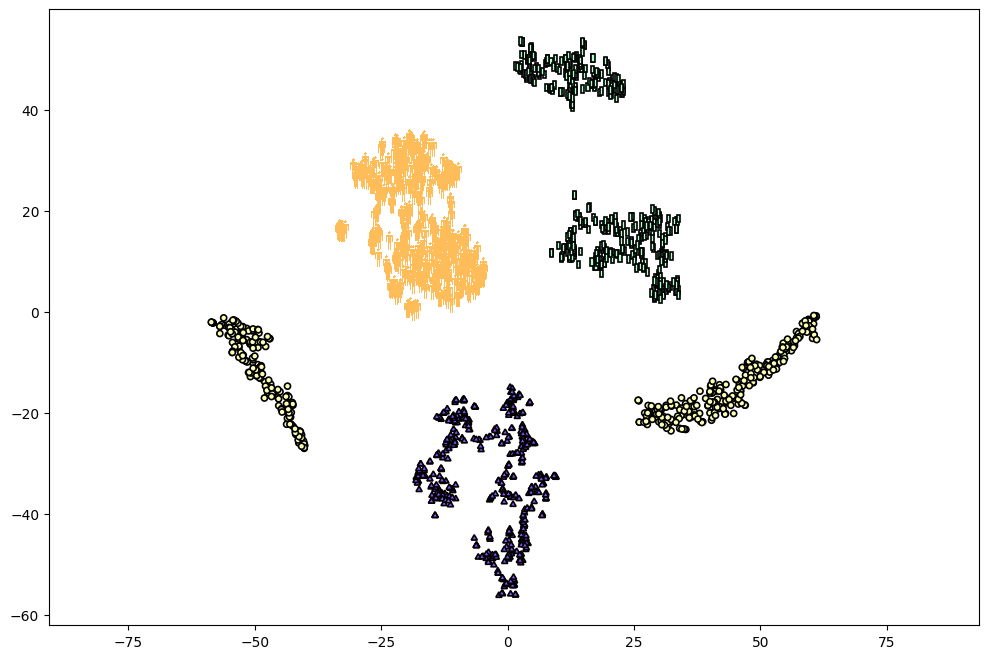

Fat Acc: -0.0076 ± 0.0250
Antro Acc: 0.0040 ± 0.0317
Muscle Acc: -0.0181 ± 0.0213
Test Fat Accuracy: -0.0181 ± 0.0276
Test Antro Accuracy: 0.0037 ± 0.0324
Test Muscle Accuracy: -0.0143 ± 0.0369


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, RegularPolygon
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import matplotlib.image as mpimg
import numpy as np
image_path = "path/to/your/person.png"  
arr_img = mpimg.imread(image_path)
fat_acc = []
antro_acc = []
muscle_acc = []
test_fat_acc = []
test_antro_acc = []
test_muscle_acc = []
total_acc_mae_ours = [] 
total_acc_mre_ours = [] 
total_acc_mse_ours = [] 
all_modalities = list(set(fat_data + antro_data + muscle_data + beta_data))
# df_gender = df[["Gender"]]
df = df[all_modalities]
modalities = ['fat', 'antro', 'muscle', 'beta']
test_folds = np.load(os.path.join(fold_base_path, 'folds.npy'), allow_pickle=True)
train_folds = np.load(os.path.join(fold_base_path, 'train_folds.npy'), allow_pickle=True)

for folder, train_fold, test_fold in zip(os.listdir(output_dir_base), train_folds, test_folds):

    output_dir = os.path.join(output_dir_base, folder)

    pre_antro_latents = load_clip_tab_data(os.path.join(output_dir, "pre_antro_latents.npy"))
    pre_demo_latents = load_clip_tab_data(os.path.join(output_dir, "pre_demo_latents.npy"))
    pre_fat_latents = load_clip_tab_data(os.path.join(output_dir, "pre_fat_latents.npy"))
    pre_muscle_latents = load_clip_tab_data(os.path.join(output_dir, "pre_muscle_latents.npy"))
    pre_beta_latents = load_clip_tab_data(os.path.join(output_dir, "pre_beta_latents.npy"))
    # Embedings from testing
    pre_test_antro_latents = load_clip_tab_data(os.path.join(output_dir, "pre_test_antro_latents.npy"))
    pre_test_demo_latents = load_clip_tab_data(os.path.join(output_dir, "pre_test_demo_latents.npy"))
    pre_test_fat_latents = load_clip_tab_data(os.path.join(output_dir, "pre_test_fat_latents.npy"))
    pre_test_muscle_latents = load_clip_tab_data(os.path.join(output_dir, "pre_test_muscle_latents.npy"))
    pre_test_beta_latents = load_clip_tab_data(os.path.join(output_dir, "pre_test_beta_latents.npy"))
    pre_reduced = load_clip_tab_data(os.path.join(output_dir, "pre_reduced.npy"))

    antro_latents = load_clip_tab_data(os.path.join(output_dir, "antro_latents.npy"))
    demo_latents = load_clip_tab_data(os.path.join(output_dir, "demo_latents.npy"))
    fat_latents = load_clip_tab_data(os.path.join(output_dir, "fat_latents.npy"))
    muscle_latents = load_clip_tab_data(os.path.join(output_dir, "muscle_latents.npy"))
    beta_latents = load_clip_tab_data(os.path.join(output_dir, "beta_latents.npy"))
    # Embedings from testing
    test_antro_latents = load_clip_tab_data(os.path.join(output_dir, "test_antro_latents.npy"))
    test_demo_latents = load_clip_tab_data(os.path.join(output_dir, "test_demo_latents.npy"))
    test_fat_latents = load_clip_tab_data(os.path.join(output_dir, "test_fat_latents.npy"))
    test_muscle_latents = load_clip_tab_data(os.path.join(output_dir, "test_muscle_latents.npy"))
    test_beta_latents = load_clip_tab_data(os.path.join(output_dir, "test_beta_latents.npy"))
    reduced = load_clip_tab_data(os.path.join(output_dir, "reduced.npy"))
    test_fat_sim, test_antro_sim, test_muscle_sim = calculate_distances(torch.tensor(pre_test_fat_latents), torch.tensor(pre_test_antro_latents), torch.tensor(pre_test_muscle_latents), torch.tensor(pre_test_beta_latents), dim=0)
    test_fat_acc.append(test_fat_sim.item())
    test_antro_acc.append(test_antro_sim.item())
    test_muscle_acc.append(test_muscle_sim.item())
    fat_sim, antro_sim, muscle_sim = calculate_distances(torch.tensor(pre_fat_latents), torch.tensor(pre_antro_latents), torch.tensor(pre_muscle_latents), torch.tensor(pre_beta_latents), dim=0)
    fat_acc.append(fat_sim.item())
    antro_acc.append(antro_sim.item())
    muscle_acc.append(muscle_sim.item())

    reduced = reduced.reshape(len(modalities), N, 2).transpose(1, 0, 2)  # (7, N, 2) -> (N, 7, 2)

    modalities = ["Fat", "Anthro", "Muscle", "Beta"]
    modality_colors = {
                        "Fat":"#fdffb6",
                        "Anthro":"#8c52ff",
                        "Muscle":"#b2ffcb", 
                        "Beta":"blue"
                    }



    for embeddings, name in zip([reduced, pre_reduced], ["reduced", "pre_reduced"]):
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        shown_labels = set()

        for i in range(len(embeddings)):
            coords = embeddings[i]
            for j, mod in enumerate(modalities):
                x, y = coords[j]
                color = modality_colors[mod]
                edge_color = 'black'
                label = mod if mod not in shown_labels else None

                if mod == "Fat":
                    patch = Circle((x, y), radius=0.6, facecolor=color, edgecolor=edge_color, linewidth=1.2, label=label)
                
                elif mod == "Beta":
                    imagebox = OffsetImage(arr_img, zoom=0.025)
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
                    ax.add_artist(ab)
                    if label is not None:
                        ax.scatter([], [], color=color, marker='D', label=label)
                
                elif mod == "Anthro":
                    patch = RegularPolygon((x, y), numVertices=3, radius=0.7, orientation=0,
                                        facecolor=color, edgecolor=edge_color, linewidth=1.2, label=label)
                
                elif mod == "Muscle":
                    patch = Rectangle((x - 0.3, y - 0.6), width=0.6, height=1.5,
                                    facecolor=color, edgecolor=edge_color, linewidth=1.2, label=label)
                
                if mod != "Beta":
                    ax.add_patch(patch)

                shown_labels.add(mod)


        plt.gca().set_aspect('equal', adjustable='datalim')
        # plt.tight_layout()
        plt.savefig(f"../analize/tsne_modalities_{name}_{folder}.png", dpi=600, bbox_inches='tight')
        plt.show()

print(f"Fat Acc: {np.mean(fat_acc):.4f} ± {np.std(fat_acc):.4f}")
print(f"Antro Acc: {np.mean(antro_acc):.4f} ± {np.std(antro_acc):.4f}")
print(f"Muscle Acc: {np.mean(muscle_acc):.4f} ± {np.std(muscle_acc):.4f}")

print(f"Test Fat Accuracy: {np.mean(test_fat_acc):.4f} ± {np.std(test_fat_acc):.4f}")
print(f"Test Antro Accuracy: {np.mean(test_antro_acc):.4f} ± {np.std(test_antro_acc):.4f}")
print(f"Test Muscle Accuracy: {np.mean(test_muscle_acc):.4f} ± {np.std(test_muscle_acc):.4f}")

## Visualization

In [ ]:
def plot_cosine_similarity_matrix_torch(indices, embeddings, title, save_path=None):

    save_path = "../assets/imgs" + save_path
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)

    embeddings_tensor = torch.nn.functional.normalize(embeddings_tensor, p=2, dim=1)

    similarity_matrix = torch.matmul(embeddings_tensor, embeddings_tensor.T).numpy()

    fig, ax = plt.subplots(figsize=(30, 28))

    sns.heatmap(
        similarity_matrix,
        cmap="coolwarm",
        cbar=True,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    # plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")
        plt.show()
    else:
        plt.show()


In [ ]:
fold_base_path = os.path.join(general_path, 'folds_exp1', 'folds.npy')
test_folds = np.load(fold_base_path, allow_pickle=True)
output_dir_base = os.path.join(general_path, 'embeddings_exp1')


fat_embeddings_indices_raw = []
antro_embeddings_indices_raw = []
muscle_embeddings_indices_raw = []
full_embeddings_indices_raw = []

for folder, test_indices in zip(os.listdir(output_dir_base), test_folds):
    output_dir = os.path.join(output_dir_base, folder)
    test_antro_latents = load_clip_tab_data(os.path.join(output_dir, "test_antro_latents.npy"))
    test_demo_latents = load_clip_tab_data(os.path.join(output_dir, "test_demo_latents.npy"))
    test_fat_latents = load_clip_tab_data(os.path.join(output_dir, "test_fat_latents.npy"))
    test_muscle_latents = load_clip_tab_data(os.path.join(output_dir, "test_muscle_latents.npy"))
    fat_embeddings_indices_raw.append((test_indices, test_fat_latents))
    antro_embeddings_indices_raw.append((test_indices, test_antro_latents))
    muscle_embeddings_indices_raw.append((test_indices, test_muscle_latents))
    full_embeddings_indices_raw.append((test_indices, np.concatenate([test_fat_latents, test_antro_latents, test_muscle_latents], axis=1)))


def global_sort_and_reindex(embeddings_indices_list):
    all_indices = []
    all_embeddings = []

    for indices, embeddings in embeddings_indices_list:
        all_indices.append(np.array(indices))
        all_embeddings.append(np.array(embeddings))

    all_indices = np.concatenate(all_indices)
    all_embeddings = np.concatenate(all_embeddings)

    sort_order = np.argsort(all_indices)
    sorted_indices = all_indices[sort_order]
    sorted_embeddings = all_embeddings[sort_order]

    new_indices = np.arange(len(sorted_indices))

    return [(new_indices, sorted_embeddings)]


fat_embeddings_indices = global_sort_and_reindex(fat_embeddings_indices_raw)
antro_embeddings_indices = global_sort_and_reindex(antro_embeddings_indices_raw)
muscle_embeddings_indices = global_sort_and_reindex(muscle_embeddings_indices_raw)
full_embeddings_indices = global_sort_and_reindex(full_embeddings_indices_raw)


plot_cosine_similarity_matrix_torch(*fat_embeddings_indices[0], title="FAT", save_path="cosine_similarity_fat.png")
plot_cosine_similarity_matrix_torch(*antro_embeddings_indices[0], title="ANTRO", save_path="cosine_similarity_antro.png")
plot_cosine_similarity_matrix_torch(*muscle_embeddings_indices[0], title="MUSCLE", save_path="cosine_similarity_muscle.png")
plot_cosine_similarity_matrix_torch(*full_embeddings_indices[0], title="FULL", save_path="cosine_similarity_full.png")


    

In [ ]:

df_sorted = df.sort_values(by=['cliente', 'sesion'])
df_first_session = df_sorted.drop_duplicates(subset='cliente', keep='first').reset_index()
print(df_first_session[['cliente', 'sesion', 'index']].head())
selected_indices = df_first_session['index'].values

def filter_embeddings_raw_by_selected_indices(embeddings_indices_list, selected_indices):
    filtered = []
    for indices, embeddings in embeddings_indices_list:
        mask = np.isin(indices, selected_indices)
        filtered_indices = indices[mask]
        filtered_embeddings = embeddings[mask]
        filtered.append((filtered_indices, filtered_embeddings))
    return filtered

fat_filtered_raw = filter_embeddings_raw_by_selected_indices(fat_embeddings_indices_raw, selected_indices)
antro_filtered_raw = filter_embeddings_raw_by_selected_indices(antro_embeddings_indices_raw, selected_indices)
muscle_filtered_raw = filter_embeddings_raw_by_selected_indices(muscle_embeddings_indices_raw, selected_indices)
full_filtered_raw = filter_embeddings_raw_by_selected_indices(full_embeddings_indices_raw, selected_indices)

fat_filtered = global_sort_and_reindex(fat_filtered_raw)
antro_filtered = global_sort_and_reindex(antro_filtered_raw)
muscle_filtered = global_sort_and_reindex(muscle_filtered_raw)
full_filtered = global_sort_and_reindex(full_filtered_raw)

plot_cosine_similarity_matrix_torch(*fat_filtered[0], title="FAT - First Session per Client", save_path="cosine_similarity_fat_first_session.png")
plot_cosine_similarity_matrix_torch(*antro_filtered[0], title="ANTRO - First Session per Client", save_path="cosine_similarity_antro_first_session.png")
plot_cosine_similarity_matrix_torch(*muscle_filtered[0], title="MUSCLE - First Session per Client", save_path="cosine_similarity_muscle_first_session.png")
plot_cosine_similarity_matrix_torch(*full_filtered[0], title="FULL - First Session per Client", save_path="cosine_similarity_full_first_session.png")


## Body Measurements dataset

In [2]:
df = pd.read_csv("../data/BodyMeasurements_original_CSV.csv")
print(df.head())
print(df.info())

   Gender  Age  HeadCircumference  ShoulderWidth  ChestWidth   Belly   Waist   \
0     1.0   30                 22             18           20      18      14   
1     1.0   28                 19             22           17      18      21   
2     2.0   27                 21             18           16      14      10   
3     1.0   29                 20             20           18      11      19   
4     2.0   28                 16             14           18      13      11   

   Hips   ArmLength   ShoulderToWaist   WaistToKnee   LegLength  TotalHeight  
0     22          22                25            25         22           52  
1     25          28                23            25         20           56  
2     15          21                18            14         18           53  
3     14          24                21            20         21           45  
4     30          25                22            32         13           47  
<class 'pandas.core.frame.DataFrame'>
R

In [ ]:
df.columns = df.columns.str.strip()

df["Gender"] = df["Gender"].replace({1: 0, 2: 1})

cols_inches = df.columns.difference(["Gender", "Age"])
df[cols_inches] = df[cols_inches] * 2.54

df["WHR"] = df["Waist"] / df["Hips"]

df.to_csv("bodycm.csv", index=False)

In [ ]:
df = pd.read_csv("../data/bodycm.csv")
df = df.rename(columns={
    "TotalHeight": "Height",
    "Hips": "Hip",
    
})

df.to_csv("../data/bodycm.csv", index=False)

In [ ]:

df_train = pd.read_csv(os.path.join(data_path, 'df_final3.csv'))

X_train = df_train[["Height", "Hip", "Waist", "WHR"]]
y_weight = df_train["Weight"]

y_wrist = df_train["Wrist"]

rf_weight = RandomForestRegressor(n_estimators=200, random_state=42)
rf_weight.fit(X_train, y_weight)

rf_wrist = RandomForestRegressor(n_estimators=200, random_state=42)
rf_wrist.fit(X_train, y_wrist)
df_new = pd.read_csv("../data/bodycm.csv")
X_new = df_new[["Height", "Hip", "Waist", "WHR"]]

df_new["Weight"] = rf_weight.predict(X_new)
df_new["Wrist"] = rf_wrist.predict(X_new)

df_new.to_csv("bodycm.csv", index=False)


In [ ]:
df_body = pd.read_csv("../data/bodycm.csv")
antro_df = df_body[["Height", "Weight", "Wrist", "Waist", "Hip", "WHR"]].copy()
fat_data = torch.tensor(df[["Total Fat", "Fat Right Leg", "Fat Left Leg", 
                                 "Fat Right Arm", "Fat Left Arm", "Fat Trunk"]].values, dtype=torch.float32)

antro_data = torch.tensor(df[["Height", "Weight", "Wrist", 
                                   "Waist", "Hip", "WHR"]].values, dtype=torch.float32)

muscle_data = torch.tensor(df[["Total Muscle", "Muscle Right Leg", "Muscle Left Leg", 
                                    "Muscle Right Arm", "Muscle Left Arm", "Muscle Trunk"]].values, dtype=torch.float32)

beta_data = torch.tensor(df[["beta0", "beta1", "beta2", "beta3", 
                                  "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]].values, dtype=torch.float32)

model_path = "../3dv_results/models_exp1/fold_0/clip_tab_model_3dv.pth"
model_dict = {
    'fat': MLPEncoder(fat_data.shape[1]),
    'antro': MLPEncoder(antro_data.shape[1]),
    'muscle': MLPEncoder(muscle_data.shape[1]),
    'beta': MLPEncoder(beta_data.shape[1])
}
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model_dict['antro'].load_state_dict(state_dict['antro'])  # clave según cómo guardaste el modelo
model_dict['antro'].eval()

antro_latents = []
with torch.no_grad():
    for i in range(len(antro_df)):
        sample = antro_df.iloc[i].values.astype(np.float32) 
        sample_tensor = torch.tensor(sample).unsqueeze(0)   
        z_antro, _ = model_dict['antro'](sample_tensor)
        antro_latents.append(z_antro.squeeze().numpy())

antro_latents = np.array(antro_latents)
np.save("../3dv_results/body_cm/antro_embeddings.npy", antro_latents)

In [ ]:
df = pd.read_csv(os.path.join(data_path, 'df_final3.csv'))  
df_body = pd.read_csv("../data/bodycm.csv") 


antro_data = ["Height", "Weight", "Wrist", "Waist", "Hip", "WHR"]
beta_data = ["beta0", "beta1", "beta2", "beta3", "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]

distance_metric = 'euclidean'
num_k = 3
modality = 'antro'

query_embeddings = np.load("../3dv_results/body_cm/antro_embeddings.npy")

test_folds = np.load(os.path.join(fold_base_path, 'folds.npy'), allow_pickle=True)
train_folds = np.load(os.path.join(fold_base_path, 'train_folds.npy'), allow_pickle=True)

df_gender = df[["Gender"]]  
df_body_gender = df_body[["Gender"]]  

all_df_embeddings = [None] * len(df) 
processed_indices = set()

for fold_idx, (folder, train_fold, test_fold) in enumerate(zip(os.listdir(output_dir_base), train_folds, test_folds)):
    
    print(f"Processing fold {fold_idx}: {folder}")
    
    output_dir = os.path.join(output_dir_base, folder)

    train_antro_latents = load_clip_tab_data(os.path.join(output_dir, "antro_latents.npy"))
    test_antro_latents = load_clip_tab_data(os.path.join(output_dir, "test_antro_latents.npy"))
    
    for train_idx, original_idx in enumerate(train_fold):
        if original_idx not in processed_indices:
            all_df_embeddings[original_idx] = train_antro_latents[train_idx]
            processed_indices.add(original_idx)
    
    for test_idx, original_idx in enumerate(test_fold):
        if original_idx not in processed_indices:
            all_df_embeddings[original_idx] = test_antro_latents[test_idx]
            processed_indices.add(original_idx)

missing_indices = [i for i, emb in enumerate(all_df_embeddings) if emb is None]
if missing_indices:
    print(f"WARNING: Missing embeddings for indices: {missing_indices[:10]}...")
    # Fill with embeddings from the first available fold
    for missing_idx in missing_indices:
        for fold_idx, (folder, train_fold, test_fold) in enumerate(zip(os.listdir(output_dir_base), train_folds, test_folds)):
            if missing_idx in train_fold:
                output_dir = os.path.join(output_dir_base, folder)
                train_antro_latents = load_clip_tab_data(os.path.join(output_dir, "antro_latents.npy"))
                train_idx = np.where(np.array(train_fold) == missing_idx)[0][0]
                all_df_embeddings[missing_idx] = train_antro_latents[train_idx]
                break
            elif missing_idx in test_fold:
                output_dir = os.path.join(output_dir_base, folder)
                test_antro_latents = load_clip_tab_data(os.path.join(output_dir, "test_antro_latents.npy"))
                test_idx = np.where(np.array(test_fold) == missing_idx)[0][0]
                all_df_embeddings[missing_idx] = test_antro_latents[test_idx]
                break

all_df_embeddings = np.array(all_df_embeddings)
all_df_indices = np.arange(len(df)) 

assert len(all_df_embeddings) == len(df), f"Missing embeddings: {len(all_df_embeddings)} != {len(df)}"

all_neighbors_data = []
all_real_data_with_gender = [] 

for query_idx in range(len(query_embeddings)):
    
    if query_idx % 100 == 0:
        print(f"Processing query {query_idx}/{len(query_embeddings)}")

    query_embedding = query_embeddings[query_idx]
    query_gender = df_body_gender.iloc[query_idx]['Gender']
    
    all_real_data_with_gender.append([None, query_gender]) 
    
    distances = []
    
    for candidate_idx in range(len(all_df_embeddings)):
        candidate_embedding = all_df_embeddings[candidate_idx]
        dist = np.linalg.norm(query_embedding - candidate_embedding)
        distances.append(dist)

    distances = np.array(distances)
    
    nearest_indices = np.argsort(distances)[:num_k]
    top_distances = distances[nearest_indices]
    
    retrieved_df_indices = nearest_indices
    
    neighbor_betas = df.iloc[retrieved_df_indices][beta_data].values
    neighbor_genders = df_gender.iloc[retrieved_df_indices]['Gender'].values
    
    epsilon = 1e-8
    inv_distances = 1 / (top_distances + epsilon)
    weights = inv_distances / inv_distances.sum()
    
    
    all_neighbors_data.append([neighbor_betas, neighbor_genders, weights])
    
    weighted_beta = np.average(neighbor_betas, axis=0, weights=weights)
all_distances_stats = []

# Calcular estadísticas de distancias para cada query
for query_idx in range(len(query_embeddings)):
    query_embedding = query_embeddings[query_idx]
    distances = []
    
    for candidate_idx in range(len(all_df_embeddings)):
        candidate_embedding = all_df_embeddings[candidate_idx]
        dist = np.linalg.norm(query_embedding - candidate_embedding)
        distances.append(dist)
    
    distances = np.array(distances)
    nearest_distances = np.sort(distances)[:num_k]
    all_distances_stats.append(nearest_distances)

all_distances_stats = np.array(all_distances_stats)

unique_genders = df_body_gender['Gender'].unique()
for gender in unique_genders:
    mask = df_body_gender['Gender'] == gender
    count = mask.sum()
    if count > 0:
        print(f"  {gender}: {count} queries")

first_neighbors = all_neighbors_data[0]
neighbor_betas, neighbor_genders, weights = first_neighbors
if 'generated_betas_path_base' in locals() and 'real_betas_path_base' in locals():
        
    neighbors_array = np.empty(len(all_neighbors_data), dtype=object)
    for i, data in enumerate(all_neighbors_data):
        neighbors_array[i] = data
        
    real_array = np.empty(len(all_real_data_with_gender), dtype=object)
    for i, data in enumerate(all_real_data_with_gender):
        real_array[i] = data
    
    
    np.save("../3dv_results/body_cm_embeddings/neighbor_embeddings.npy", neighbors_array)
    np.save("../3dv_results/body_cm_embeddings/real_embeddings.npy", real_array)